In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib widget

from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np

In [2]:
graph = Graph()

**Part 1 : read the articles category file**
Populate the graph with articles, categories and categories 

In [3]:
graph.update_graph("data/categories.tsv", edges=False, verbose=True)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
0 in the articles graph,
0 in the categories graph,
0 in the topics graph.


**Part 2 : Add the edges between the vertices**

In [4]:
graph.update_graph("data/paths_finished.tsv", edges=True, verbose=True) 

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
50354 in the articles graph,
6530 in the categories graph,
208 in the topics graph.


In [5]:
graph.update_graph("data/paths_unfinished.tsv", edges=True, verbose=True)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
57572 in the articles graph,
6931 in the categories graph,
208 in the topics graph.


**get top 10 categories**

In [6]:
def vertices_to_df(graph, level):
    assert level in graph.authorized_levels
    _, verteces = graph.levels_map[level]
    header =["Topic", "Category", "nb_unique_edges", "nb_unique_outgoing_edges", "nb_unique_incoming_edges", "total_weight" ,"total_weight_out", "total_weight_in","average_weight_per_edge", "average_weight_out", "average_weight_in"]  
    if level == "categories":
        header.remove("Category")
        header.append("nb_articles")
    if level == "topics":
        header.remove("Topic")
        header.remove("Category")
        header.append("nb_categories")
        header.append("nb_articles")
    
    df = pd.DataFrame(columns=header)
    for vertex in verteces.values():
        nb_unique_outgoing_edges = vertex.get_nb_different_out_neighbours()
        nb_unique_incoming_edges = vertex.get_nb_different_in_neighbours()
        nb_unique_edges = nb_unique_outgoing_edges + nb_unique_incoming_edges
        
        if (nb_unique_edges != 0) :
            total_weight_out = vertex.get_total_out_weight()
            total_weight_in = vertex.get_total_in_weight()
            total_weight = total_weight_out + total_weight_in
            average_weight_out = round(total_weight_out/nb_unique_outgoing_edges, 2) if nb_unique_outgoing_edges != 0 else 0
            average_weight_in = round(total_weight_in/nb_unique_incoming_edges,2) if nb_unique_incoming_edges != 0 else 0
            average_weight_per_edge = round(total_weight/nb_unique_edges, 2)

            if level == "articles":
                df.loc[vertex.title] = [vertex.topic, vertex.category, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in]
                df["Topic"].astype("category")
                df["Category"].astype("category")
            elif level == "categories":
                df.loc[vertex.title]= [vertex.topic, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_articles()]
                df["Topic"].astype("category")
            else:
                df.loc[vertex.title]= [nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_categories(), vertex.get_nb_different_articles()]
    return df

In [7]:
df_articles = vertices_to_df(graph, level="articles")
df_categrories = vertices_to_df(graph, level="categories")
df_topics = vertices_to_df(graph, level="topics")

**in Size**

In [37]:
df_articles.sort_values(by=["total_weight"], ascending=True)


,Topic,Category,nb_unique_edges,nb_unique_outgoing_edges,nb_unique_incoming_edges,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
Rock_Bunting,Science,Birds,1,1,0,1,1,0,1.00,1.00,0.00
Portuguese_Communist_Party,Citizenship,Politics_and_government,1,1,0,1,1,0,1.00,1.00,0.00
Endoscopic_foreign_body_retrieval,Science,Health_and_medicine,1,1,0,1,1,0,1.00,1.00,0.00
Colditz_Castle,History,Military_History_and_War,1,1,0,1,1,0,1.00,1.00,0.00
Psittacosaurus,Science,Dinosaurs,1,1,0,1,1,0,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Earth,Science,The_Planets,343,112,231,7960,3950,4010,23.21,35.27,17.36
England,Geography,Geography_of_Great_Britain,733,165,568,8140,3978,4162,11.11,24.11,7.33
United_Kingdom,Geography,Geography_of_Great_Britain,840,167,673,9819,4817,5002,11.69,28.84,7.43
Europe,Geography,European_Geography,847,147,700,10599,5285,5314,12.51,35.95,7.59


In [9]:
df_categrories.sort_values(by=["average_weight_out"], ascending=False).head(5)

,Topic,nb_unique_edges,nb_unique_outgoing_edges,nb_unique_incoming_edges,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_articles
Countries,Countries,219,101,118,5734,2401,3333,26.18,23.77,28.25,229
Chemical_elements,Science,151,72,79,2402,1229,1173,15.91,17.07,14.85,119
Politics_and_government,Citizenship,207,91,116,3307,1512,1795,15.98,16.62,15.47,97
North_American_Geography,Geography,225,102,123,4264,1448,2816,18.95,14.20,22.89,103
European_Countries,Geography,227,105,122,4393,1423,2970,19.35,13.55,24.34,56


In [10]:
df_topics.sort_values(by=["average_weight_out"], ascending=False).head(5)

,nb_unique_edges,nb_unique_outgoing_edges,nb_unique_incoming_edges,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
Geography,28.0,14.0,14.0,18549.0,7368.0,11181.0,662.46,526.29,798.64,21.0,1084.0
People,28.0,14.0,14.0,8691.0,5510.0,3181.0,310.39,393.57,227.21,20.0,708.0
Science,28.0,14.0,14.0,9297.0,5364.0,3933.0,332.04,383.14,280.93,18.0,1122.0
History,28.0,14.0,14.0,7721.0,3827.0,3894.0,275.75,273.36,278.14,14.0,545.0
Everyday_life,28.0,14.0,14.0,5335.0,3076.0,2259.0,190.54,219.71,161.36,12.0,374.0


# Study Topics

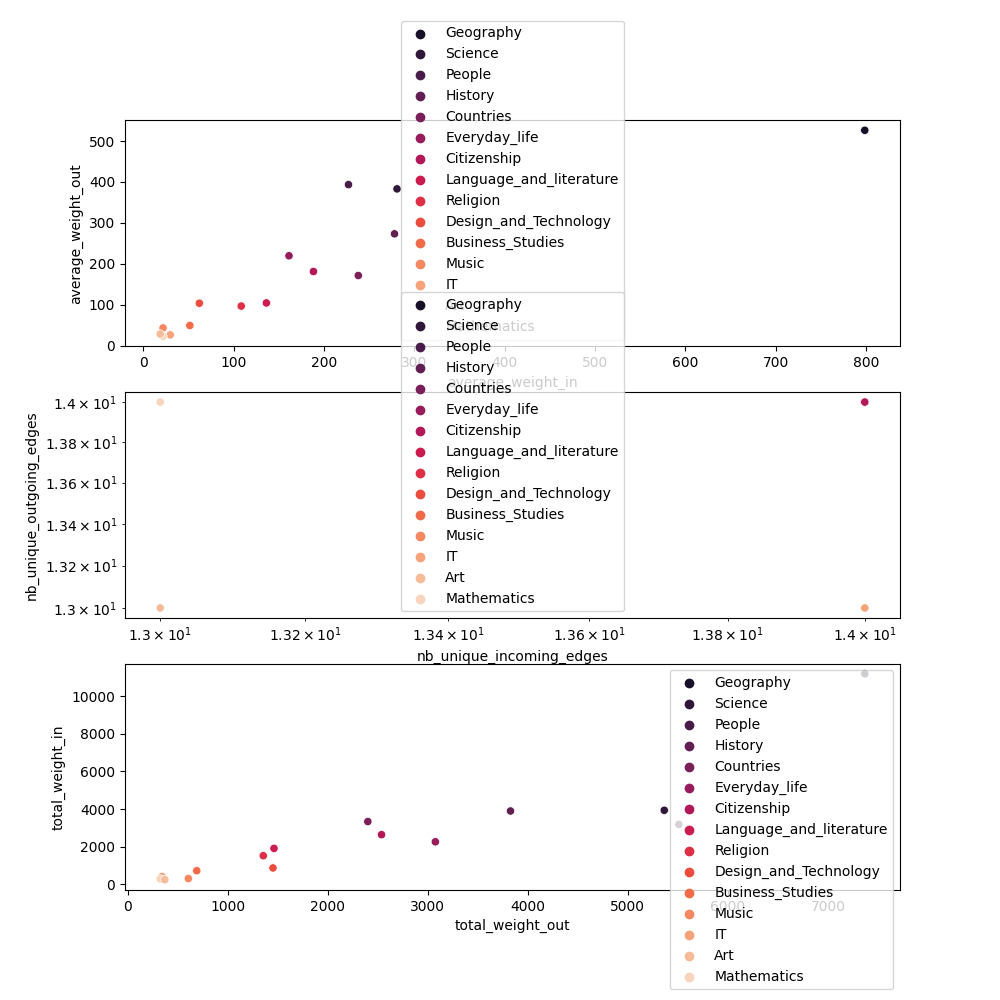

In [14]:
figure , ax = plt.subplots( 3, 1, figsize=(10,10))
#set  a logaritmic scale for the x axis

ax[1].set_xscale("log")
ax[1].set_yscale("log")

#order topics by total weight and get indeces in a list
topics_order = df_topics.sort_values(by=["total_weight"], ascending=False).index.tolist()

sns.scatterplot(data=df_topics, x="average_weight_in", y="average_weight_out", ax=ax[0], hue=list(df_topics.index), hue_order=topics_order, palette = "rocket")
sns.scatterplot(data=df_topics, x="nb_unique_incoming_edges", y="nb_unique_outgoing_edges", ax=ax[1], hue=list(df_topics.index), hue_order=topics_order, palette = "rocket")
sns.scatterplot(data=df_topics, x="total_weight_out", y="total_weight_in", ax=ax[2], hue=list(df_topics.index), hue_order=topics_order, palette = "rocket")
mplcursors.cursor(hover=True)

<AxesSubplot:xlabel='total_weight_out', ylabel='total_weight_in'>

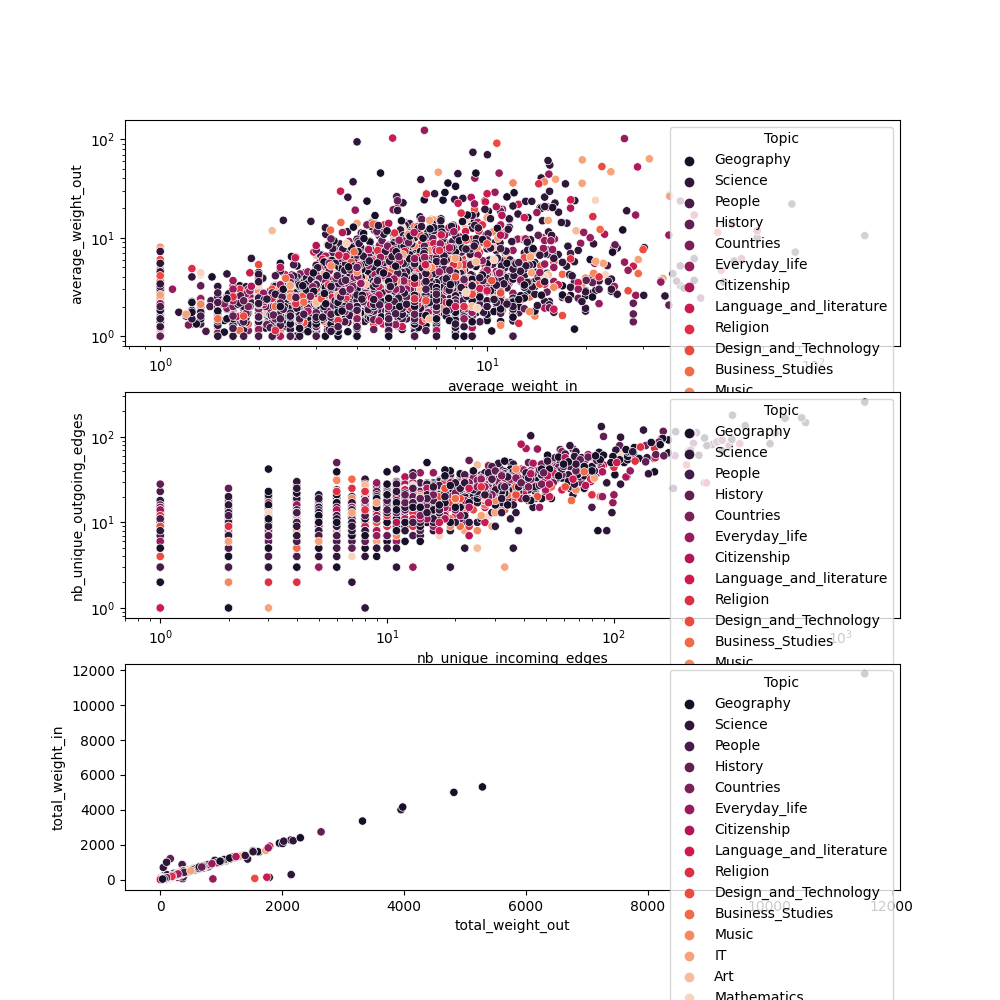

In [15]:
figure , ax = plt.subplots( 3, 1, figsize=(10,10))
#set  a logaritmic scale for the x axis
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")

#order topics by total weight and get indeces in a list
topics_order = df_topics.sort_values(by=["total_weight"], ascending=False).index.tolist()
sns.scatterplot(data=df_articles, x="average_weight_in", y="average_weight_out", ax=ax[0], hue="Topic", hue_order=topics_order, palette = "rocket")
sns.scatterplot(data=df_articles, x="nb_unique_incoming_edges", y="nb_unique_outgoing_edges", ax=ax[1], hue="Topic", hue_order=topics_order, palette = "rocket")
sns.scatterplot(data=df_articles, x="total_weight_out", y="total_weight_in", ax=ax[2], hue="Topic", hue_order=topics_order, palette = "rocket")



In [13]:
#nx.draw_random(G1,node_color = colors,labels = labels,with_labels = True) 
n = len(df_topics)
#color = color_list(n)
color =['#445148', '#4a136c', '#502590', '#5636b3', '#5653b1',
        '#4e7a88', '#47a05f', '#40c736', '#ffbc3f', '#ffa426',
        '#ff8c0d', '#ff7504', '#ff5e0b', '#ff4812', '#ff3219']

labels = list(graph.topics.keys())
# map each category to a color
color_map = {category: color[i] for i, category in enumerate(graph.topics.keys())}

G1 = nx.DiGraph()
size = [df_topics()*25 for t in list(graph.topics.values())]
#loop on graph.matrixt
for key, value in graph.matrix_topics.items():
    for key2, value2 in value.items():
            G1.add_edge(key,key2,weight=value2, color=color_map[key])


color = []
for node in G1.nodes(): 
    color.append(color_map[node])


label_dict = {}
for i in range(len(labels)):
    label_dict[labels[i]] = labels[i]
plt.figure(figsize=(15,15))

edges = G1.edges()
weights = [G1[u][v]['weight']/500 for u,v in edges]
colors = [G1[u][v]['color'] for u,v in edges]
nx.draw_circular(G1,node_size = size,node_color = color,labels=label_dict, width= weights, edge_color=colors)
plt.show()

TypeError: 'DataFrame' object is not callable

In [ ]:
nodePos = nx.circular_layout(G1)

In [ ]:
nodePos

In [ ]:
graph.matrix['Art']

In [ ]:
#design1


#nx.draw_random(G1,node_color = colors,labels = labels,with_labels = True) 
n = graph.nb_categories
#color = color_list(n)
color = ['#445148', '#4a136c', '#502590', '#5636b3', '#5653b1',
        '#4e7a88', '#47a05f', '#40c736', '#ffbc3f', '#ffa426',
        '#ff8c0d', '#ff7504', '#ff5e0b', '#ff4812', '#ff3219']
#'#440148
labels = list(graph.categories.keys())
# map each category to a color
color_map = {category: color[i] for i, category in enumerate(graph.categories.keys())}
print(color_map)
G1 = nx.DiGraph()
size = [t.size*40 for t in list(graph.categories.values())]
#loop on graph.matrixt
for key, value in graph.matrix.items():
    for key2, value2 in value.items():
     
            G1.add_edge(key,key2,weight=value2, color=color_map[key])
      


color = []
for node in G1.nodes(): 
    color.append(color_map[node])
  



label_dict = {}
for i in range(len(labels)):
    label_dict[labels[i]] = labels[i]
plt.figure(figsize=(15,15))

edges = G1.edges()
weights = [G1[u][v]['weight']/500 for u,v in edges]
colors = [G1[u][v]['color'] for u,v in edges]

nodePos = nx.circular_layout(G1)
nodePos['People'] = [ -0.5, 0]
nodePos['Citizenship'] = [0.7,0]
nodePos['Geography'] = [0,0.1]
nodePos['Science'] = [-0.5,0.5]
nodePos['Everyday_life'] = [-0.75,0.25]
nodePos['History'] = [0,0.5]
nodePos['Countries'] = [0.3,0.3]
nodePos['Design_and_Technology'] = [0,-0.3]
nodePos['Language_and_literature'] = [-0.3,-0.3]
nodePos['Religion'] = [0.1,-0.1]

nodePos['Mathematics'] = [0,-0.4]
nodePos['Art'] = [-0.5,-0.4]
nodePos['IT'] = [-1,0]

nodePos['Music'] = [0.5,-0.4]
nodePos['Business_Studies'] = [0.3,-0.3]

#people,science citizenship geograpgy  everydaylife
nx.draw(G1,node_size = size,pos = nodePos,node_color = color,labels=label_dict, width= weights, edge_color=colors)
plt.show()